# Face Recognition

import the libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder

https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset/

Download dataset
and read it

In [2]:
# import zipfile
# zip_ref = zipfile.ZipFile("data_1.zip", 'r')
# zip_ref.extractall()
# zip_ref.close()

[[ 35  57 160 160]]


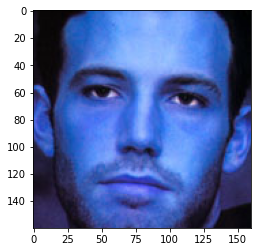

In [3]:
face_cascade = cv2.CascadeClassifier('haar.xml')
f = cv2.imread("data/train/ben_afflek/httpwwwallposterscomimagesPostersPFjpg.jpg")
faces = face_cascade.detectMultiScale(f,1.3,5)
print(faces)
for x,y,w,h in faces:
    plt.imshow(f[y:y+h, x:x+w])

Create dataset

In [4]:
face_cascade = cv2.CascadeClassifier('haar.xml')
dirs = "data/train/"
img_size = 60

data = []
for name in os.listdir(dirs):
    for f in os.listdir(dirs+name):
        f = cv2.imread(os.path.join(dirs+name, f))
        faces = face_cascade.detectMultiScale(f,1.3,5)
        for x,y,w,h in faces:
            img = f[y:y+h, x:x+w]
            img = cv2.resize(img, (img_size,img_size))
            data.append((img, name))
            
df = pd.DataFrame(data, columns=["image", "name"])
print("Length:",len(df))

Length: 99


Name:  mindy_kaling
(60, 60, 3)


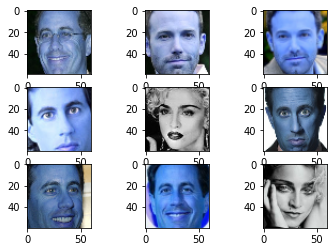

In [5]:
idx = 34
row = df.iloc[idx, :]
print("Name: ", row["name"])
print(row.image.shape)
for i in range(9):
  row = df.iloc[np.random.randint(0, len(df)), :]
  plt.subplot(3,3,i+1)
  plt.imshow(row.image)

create test data

In [6]:
dirs = "data/val/"

data = []
for name in os.listdir(dirs):
    for f in os.listdir(dirs+name):
        f = cv2.imread(os.path.join(dirs+name, f))
        faces = face_cascade.detectMultiScale(f,1.3,5)
        for x,y,w,h in faces:
            img = f[y:y+h, x:x+w]
            img = cv2.resize(img, (img_size,img_size))
            data.append((img, name))
            
df_test = pd.DataFrame(data, columns=["image", "name"])
print("Test size: ", len(df_test))

Test size:  24


## Preprocess data

In [7]:
le = LabelEncoder()
le.fit(df["name"].values)

LabelEncoder()

Training data

In [8]:
x_train = list(df.image.values)
x_train = np.array(x_train)
x_train = x_train/255
print(x_train.shape)

y_train = le.transform(df["name"].values)
print(y_train.shape)

(99, 60, 60, 3)
(99,)


Testing data

In [9]:
x_test = list(df_test.image.values)
x_test = np.array(x_test)
x_test = x_test/255
print(x_test.shape)

y_test = le.transform(df_test["name"].values)
print(y_test.shape)

(24, 60, 60, 3)
(24,)


## Prepare and Fit Models

In [10]:
people_num = len(np.unique(y_train))
people_num

5

#### Normal Model

In [11]:
def get_model():
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(img_size,img_size,3), activation='relu'))
        model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
        model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
        model.add(tf.keras.layers.Conv2D(64, kernel_size=1, strides=2, padding='same', activation='relu'))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(256, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(people_num, activation="softmax"))

        model.summary()
        return model

In [12]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
model = get_model()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

2022-04-07 05:28:15.491554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-07 05:28:15.519678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-07 05:28:15.520057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 64)          4160      
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0

2022-04-07 05:28:15.521350: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-07 05:28:15.522903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-07 05:28:15.523196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-07 05:28:15.523396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [13]:
weight_dir = "weight_normal_model"
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
    
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_dir+'/checkpoint-{epoch:02d}.hdf5')

In [14]:
model.fit(x_train,y_train,validation_data=(x_test, y_test),epochs=50, batch_size=100, callbacks=[checkpoint])

Epoch 1/50


2022-04-07 05:28:17.619875: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301


1/1 [==============================] - 2s 2s/step - loss: 1.6058 - accuracy: 0.2525 - val_loss: 1.6008 - val_accuracy: 0.2083
Epoch 2/50
1/1 [==============================] - 0s 70ms/step - loss: 1.5879 - accuracy: 0.2929 - val_loss: 1.5953 - val_accuracy: 0.2083
Epoch 3/50
1/1 [==============================] - 0s 70ms/step - loss: 1.5524 - accuracy: 0.2727 - val_loss: 1.6017 - val_accuracy: 0.2083
Epoch 4/50
1/1 [==============================] - 0s 70ms/step - loss: 1.5471 - accuracy: 0.2727 - val_loss: 1.5710 - val_accuracy: 0.2917
Epoch 5/50
1/1 [==============================] - 0s 69ms/step - loss: 1.5034 - accuracy: 0.3838 - val_loss: 1.5144 - val_accuracy: 0.3333
Epoch 6/50
1/1 [==============================] - 0s 70ms/step - loss: 1.4530 - accuracy: 0.4141 - val_loss: 1.4374 - val_accuracy: 0.6250
Epoch 7/50
1/1 [==============================] - 0s 69ms/step - loss: 1.4266 - accuracy: 0.4949 - val_loss: 1.3622 - val_accuracy: 0.5833
Epoch 8/50
1/1 [========================

#### Using Triplet Loss

In [15]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    total_lenght = y_pred.shape.as_list()[-1]
    anchor, positive, negative = y_pred[:,:int(1/3*total_lenght)], y_pred[:,int(1/3*total_lenght):int(2/3*total_lenght)], y_pred[:,int(2/3*total_lenght):]
    
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))
    return loss

In [16]:
def generate_triplets(x, y, num_same = 4, num_diff = 4):
    anchor_images = np.array([]).reshape((-1,)+ x.shape[1:])
    same_images = np.array([]).reshape((-1,)+ x.shape[1:])
    diff_images = np.array([]).reshape((-1,)+ x.shape[1:])
    
    for i in range(len(y)):
        point = y[i]        
        anchor = x[i]
        
        same_pairs = np.where(y == point)[0]
        same_pairs = np.delete(same_pairs , np.where(same_pairs == i))
        diff_pairs = np.where(y != point)[0]
               
        same = x[np.random.choice(same_pairs,num_same)]
        diff = x[np.random.choice(diff_pairs,num_diff)]
        
        anchor_images = np.concatenate((anchor_images, np.tile(anchor, (num_same * num_diff, 1, 1, 1) )), axis = 0)
                                       
        for s in same:
            same_images = np.concatenate((same_images, np.tile(s, (num_same, 1, 1, 1) )), axis = 0)
            
        diff_images = np.concatenate((diff_images, np.tile(diff, (num_diff, 1, 1, 1) )), axis = 0)
        
    return anchor_images, same_images, diff_images

In [17]:
anchor_images, same_images, diff_images = generate_triplets(x_train,y_train, num_same= 10, num_diff=10)
print(anchor_images.shape, same_images.shape, diff_images.shape)

(9900, 60, 60, 3) (9900, 60, 60, 3) (9900, 60, 60, 3)


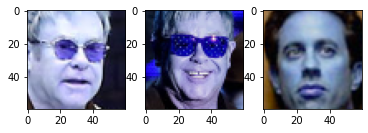

In [18]:
idx = 90
plt.subplot(1,3,1)
plt.imshow(anchor_images[idx])

plt.subplot(1,3,2)
plt.imshow(same_images[idx])

plt.subplot(1,3,3)
plt.imshow(diff_images[idx])

In [19]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(img_size,img_size,3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=1, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128))
              
    model.summary()
    return model

In [21]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
anchor_input = tf.keras.layers.Input((img_size, img_size, 3), name='anchor_input')
positive_input = tf.keras.layers.Input((img_size, img_size, 3), name='positive_input')
negative_input = tf.keras.layers.Input((img_size, img_size, 3), name='negative_input')

shared_dnn = get_model()

encoded_anchor = shared_dnn(anchor_input)
encoded_positive = shared_dnn(positive_input)
encoded_negative = shared_dnn(negative_input)

merged_vector = tf.keras.layers.concatenate([encoded_anchor, encoded_positive, encoded_negative],
                                            axis=-1, name='merged_layer')

model = tf.keras.Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.summary()
model.compile(loss=triplet_loss, optimizer="adam")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 64)          4160      
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0

In [22]:
weight_dir = "weight_tripletloss_model"
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
    
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_dir+'/checkpoint-{epoch:02d}.hdf5')

In [23]:
Y_dummy = np.empty((anchor_images.shape[0],1))

model.fit([anchor_images,same_images,diff_images],y=Y_dummy, batch_size=128, epochs=100, callbacks=[checkpoint])

Epoch 1/100
78/78 [==============================] - 3s 27ms/step - loss: 8.7835
Epoch 2/100
78/78 [==============================] - 2s 26ms/step - loss: 0.8038
Epoch 3/100
78/78 [==============================] - 2s 26ms/step - loss: 0.2943
Epoch 4/100
78/78 [==============================] - 2s 26ms/step - loss: 0.2855
Epoch 5/100
78/78 [==============================] - 2s 26ms/step - loss: 0.0988
Epoch 6/100
78/78 [==============================] - 2s 26ms/step - loss: 0.1817
Epoch 7/100
78/78 [==============================] - 2s 26ms/step - loss: 0.1927
Epoch 8/100
78/78 [==============================] - 2s 26ms/step - loss: 0.1832
Epoch 9/100
78/78 [==============================] - 2s 26ms/step - loss: 0.4051
Epoch 10/100
78/78 [==============================] - 2s 26ms/step - loss: 0.2429
Epoch 11/100
78/78 [==============================] - 2s 26ms/step - loss: 0.2716
Epoch 12/100
78/78 [==============================] - 2s 26ms/step - loss: 0.1509
Epoch 13/100
78/78 [=====

78/78 [==============================] - 2s 27ms/step - loss: 0.0418
Epoch 100/100
78/78 [==============================] - 2s 27ms/step - loss: 0.0000e+00


In [24]:
anchor_model = tf.keras.Model(inputs = anchor_input, outputs=encoded_anchor)

In [25]:
pred = anchor_model.predict(x_train)
pred.shape

(99, 128)

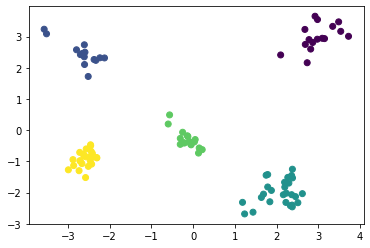

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pred_pca = pca.fit_transform(pred)

plt.scatter(pred_pca[:,0], pred_pca[:,1], c=y_train)

In [27]:
def encode_image(model ,img):
    encode = model.predict(img.reshape((1,)+ img.shape))
    return encode

In [28]:
def dist_imgs(anchor_enc, img_enc):
    return np.linalg.norm(img_enc - anchor_enc)

In [29]:
name_dict = {}
for i in set(df["name"].values):
    z = df[df["name"] == i].image
    img = np.array(list(z))/255
    enc = np.zeros((1,128))
    for j in range(len(z)):
        enc += encode_image(anchor_model,img[j])

    enc = enc/len(z)
    name_dict[i] = enc

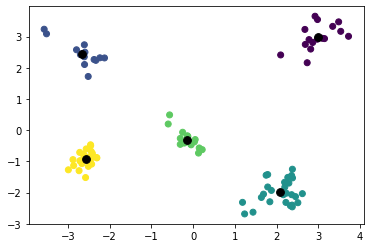

In [30]:
pca = PCA(n_components=2)
pred_pca = pca.fit_transform(pred)

plt.scatter(pred_pca[:,0], pred_pca[:,1], c=y_train)

for val in name_dict.values():
  point = pca.transform(val)
  plt.scatter(point[0,0], point[0,1], s = [60], c='black')
plt.show()

In [31]:
def predict_image(model, img, dictionary):
    enc = encode_image(model, img)
    max_dist = 10000000
    max_name = None
    for name in dictionary:
        dist = dist_imgs(dictionary[name], enc)
        if max_dist > dist:
            max_dist = dist
            max_name = name
    
    return max_name, max_dist

Predicted name: ben_afflek  with distance 0.5943376840452914
Actual pred:  ['ben_afflek']


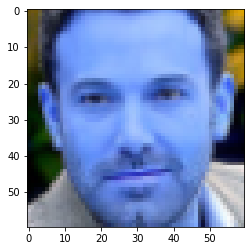

In [32]:
idx = 70
img = x_train[idx]
plt.imshow(img)

n, d = predict_image(anchor_model, img, name_dict)
print("Predicted name:",n ," with distance", d)
print("Actual pred: ", le.inverse_transform(y_train[idx:idx+1]))

Use K-means algo on encodings

In [33]:
pred_x_train = anchor_model.predict(x_train)

In [34]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(pred_x_train, y_train) 

KNeighborsClassifier(n_neighbors=7)

Predicted name: ['ben_afflek']
Actual pred:  ['ben_afflek']


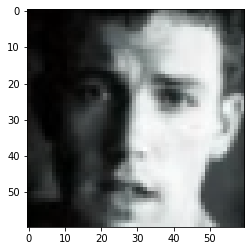

In [35]:
idx = 16
img = x_test[idx]
plt.imshow(img)

enc = encode_image(anchor_model, img)
pred = neigh.predict(enc)
print("Predicted name:",le.inverse_transform(pred))
print("Actual pred: ", le.inverse_transform(y_test[idx:idx+1]))

In [36]:
pred_x_test = anchor_model.predict(x_test)
pred = neigh.predict(pred_x_test)

print(np.sum(pred == y_test)/len(pred))


1.0
